## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Кириченко Анатолий Вадимович

In [3]:
!pip install torchvision

DEPRECATION: Loading egg at /Users/anatoliy/anaconda3/lib/python3.11/site-packages/utils-1.0.0-py3.11-macosx-11.1-arm64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/anatoliy/anaconda3/lib/python3.11/site-packages/utils-1.0.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/a8/95/affe174621ebc9b32544a918ae6cb758ac06061d0ee51d783e06906ceba1/torchvision-0.17.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torch==2.2.1 from https://files.pythonhosted.org/packages/3e/b9/256ab23c859cbcd7d6fb7cb46417a07eac817881a0a68df8ea0c18f45221/torch-2.2.1-cp311-none-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:0000:0

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 26 февраля.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [6]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 10296994.48it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 43573990.58it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 6357283.27it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2878593.04it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
images_train, labels_train = next(iter(train_loader))

In [8]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

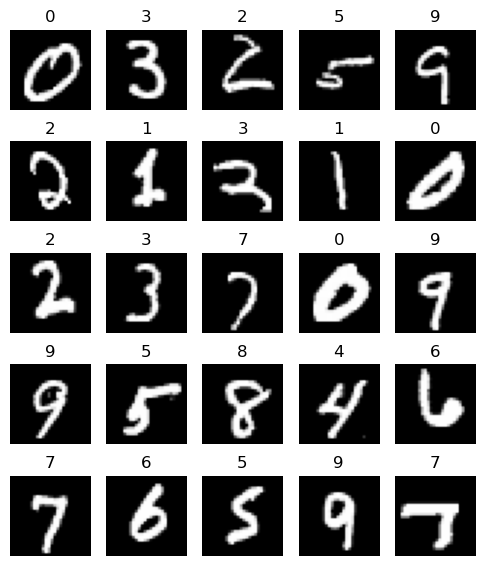

In [9]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [10]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [11]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [12]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

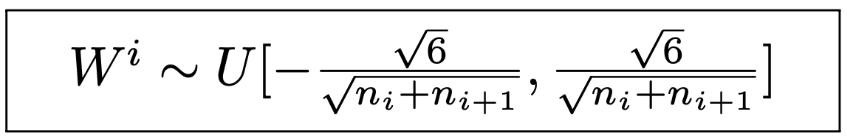

In [13]:
def init_layer_xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    uniform_border = (6 ** 0.5) / ((weight.shape[0] + weight.shape[1]) ** 0.5)
    weight.uniform_(-uniform_border, uniform_border)


layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer_xavier(layer_1)
init_layer_xavier(layer_2)

In [14]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [15]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.011785864830017
forward 0.6501879692077637
backward 0.031269438564777374
backward 0.011153381317853928


/Users/anatoliy/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Значения дисперсии показались странными. Ожидал, что они должны быть меньше. Сравним с torch реализацией

In [16]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

torch.nn.init.xavier_uniform(layer_1.weight)
torch.nn.init.xavier_uniform(layer_2.weight)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.011785864830017
forward 0.6501879692077637
backward 0.031269438564777374
backward 0.011153381317853928


/var/folders/dq/_sbk_kkx4dv43z84pnfqbpyh0000gn/T/ipykernel_19890/801473708.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer_1.weight)
/var/folders/dq/_sbk_kkx4dv43z84pnfqbpyh0000gn/T/ipykernel_19890/801473708.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer_2.weight)


Значения сходятся с реализацией из PyTorch ,но непонятно, почему получаются такие большие значения дисперсии при прямом проходе

В сравнении с He также значения дисперсии при прямом проходе получаются гораздо выше

Не до конца понимаю, почему в лекции был предложен именно Normalized Xavier Initialization, хотя в оригинальной статье увидел Xavier Initialization = 2 / (n_in + n_out). Но я так понимаю, что классическая Xavier Initialization подходит исключительно в тех случаях, когда функция активации = tanh

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

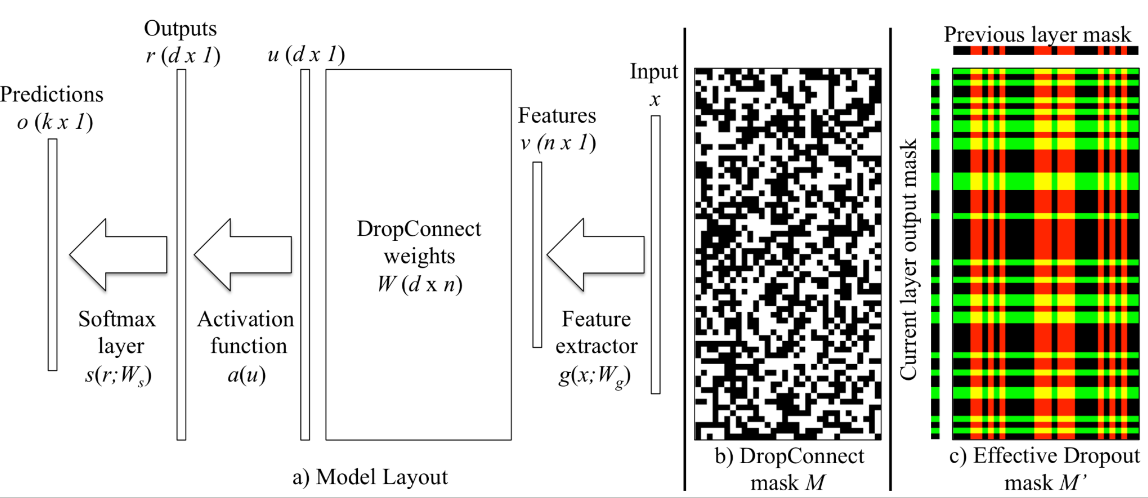

In [17]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

from torch.distributions import Bernoulli

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p
        self.dist = Bernoulli(torch.FloatTensor([self.p]))
        

    def forward(self, x):
        if self.training:
            mask = self.dist.sample(self.linear.weight.shape).squeeze(-1)
        else:
            mask = torch.ones(self.linear.weight.shape).squeeze(-1)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [18]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [19]:
from torch.distributions import Bernoulli

distribution = Bernoulli(torch.FloatTensor([0.5]))

a = torch.FloatTensor([[0.3, 0.4, 0.5], [0.1, 0.5, 0.8]])

distribution.sample(a.shape).squeeze(-1)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

Основа для сети, которую будем обучать:

In [20]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [21]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

In [22]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [29]:
def train(network, train_loader, test_loader):
    
    epoches_losses = {'train_losses': [], 'validation_losses': []}
    
    for epoch in range(10):
        network.train()
        train_loss = 0
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        epoches_losses['train_losses'].append(train_loss / batch_idx)
        network.eval()
        losses = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)

            losses.append(loss.item())

        epoches_losses['validation_losses'].append(np.mean(losses))
        
        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses)))
        
            
    return epoches_losses


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [30]:
layers_with_dropconnect = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

layers_with_droupout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

network_with_dropconnect = TestNetwork(nn.Sequential(*layers_with_dropconnect))
optimizer = torch.optim.Adam(network_with_dropconnect.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

losses_network_dropconnect = train(network_with_dropconnect, train_loader, test_loader)

network_with_dropout = TestNetwork(nn.Sequential(*layers_with_droupout))
optimizer = torch.optim.Adam(network_with_dropout.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

losses_network_droupout = train(network_with_dropout, train_loader, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297644
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.598189
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.960520
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.882712
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.637266
Test Epoch: 0	Loss: 1.369794
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.411444
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.618442
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.461664
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.281516
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.401964
Test Epoch: 1	Loss: 1.033720
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.458290
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.515787
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.492996
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.376994
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.511811
Test Epoch: 2	Loss: 0.806460
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.261667
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.228510
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.394766
Train Epoch: 3 [38400/60000 (64%)

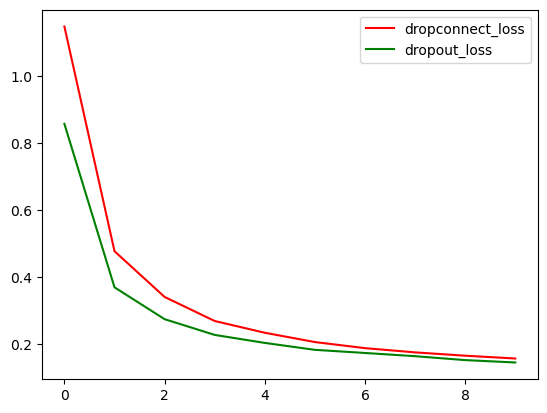

In [43]:
plt.plot(losses_network_dropconnect['train_losses'], color='r')
plt.plot(losses_network_droupout['train_losses'], color='g')
plt.legend(['dropconnect_train_loss', 'dropout_train_loss'])
plt.show()

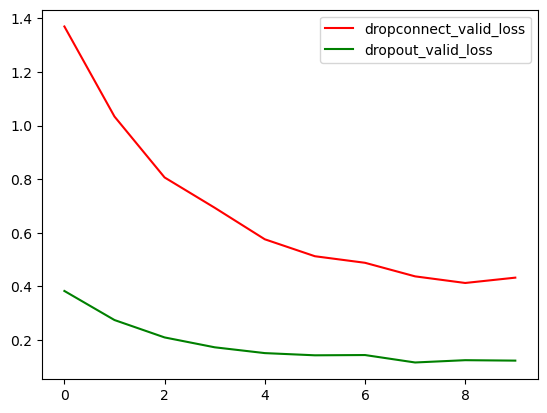

In [48]:
plt.plot(losses_network_dropconnect['validation_losses'], color='r')
plt.plot(losses_network_droupout['validation_losses'], color='g')
plt.legend(['dropconnect_valid_loss', 'dropout_valid_loss'])
plt.show()

На графиках видно, что при использовании дропаута функция потерь на трейне и на валидации падает гораздо быстрее

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

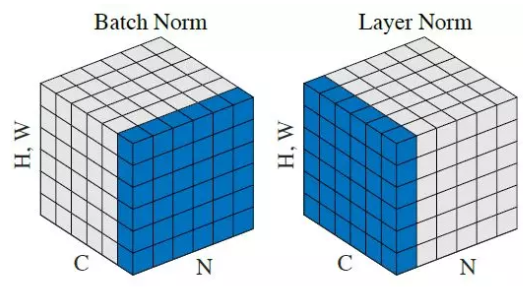

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [89]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(axis=1)[:, None]
        var = x.var(axis=1)[:, None]
        output = (x - mean) / (torch.sqrt(var))
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

Взял реализацию BatchNorm из torch, для сравнения

In [90]:
layers_with_layer_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

layers_with_batch_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

In [91]:
network_layers_norm = TestNetwork(nn.Sequential(*layers_with_layer_norm))
optimizer = torch.optim.Adam(network_layers_norm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

losses_network_layers_norm = train(network_layers_norm, train_loader, test_loader)

network_batch_norm = TestNetwork(nn.Sequential(*layers_with_batch_norm))
optimizer = torch.optim.Adam(network_batch_norm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

losses_network_batch_norm = train(network_batch_norm, train_loader, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.368521
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.279833
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.255619
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.152035
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.108607
Test Epoch: 0	Loss: 0.107951
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.144681
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.150837
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.090949
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.098685
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.059180
Test Epoch: 1	Loss: 0.073065
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.092422
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080587
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.082655
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.065468
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.101257
Test Epoch: 2	Loss: 0.072520
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.083863
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.061911
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.012568
Train Epoch: 3 [38400/60000 (64%)

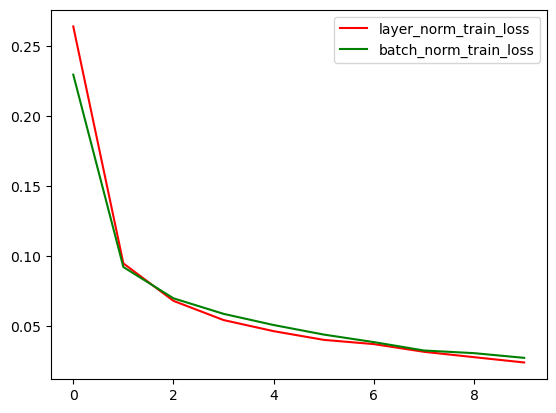

In [93]:
plt.plot(losses_network_layers_norm['train_losses'], color='r')
plt.plot(losses_network_batch_norm['train_losses'], color='g')
plt.legend(['layer_norm_train_loss', 'batch_norm_train_loss'])
plt.show()

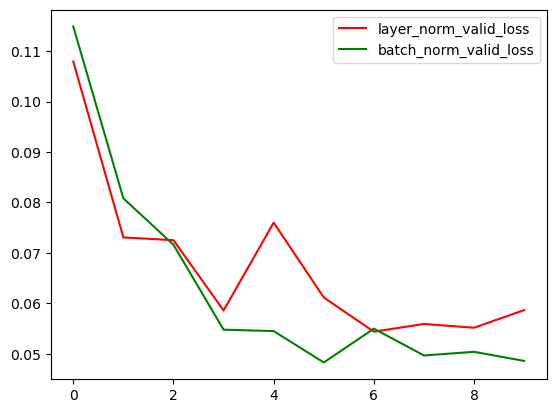

In [92]:
plt.plot(losses_network_layers_norm['validation_losses'], color='r')
plt.plot(losses_network_batch_norm['validation_losses'], color='g')
plt.legend(['layer_norm_valid_loss', 'batch_norm_valid_loss'])
plt.show()

На графиках видно, что на трейне между layer norm и batch norm никакой разницы практически нет

В случае функции потерь на валидации, batch norm показывает результаты лучше, так как функция потерь убывает и не имеет резких скачков связанных с увеличением значения.